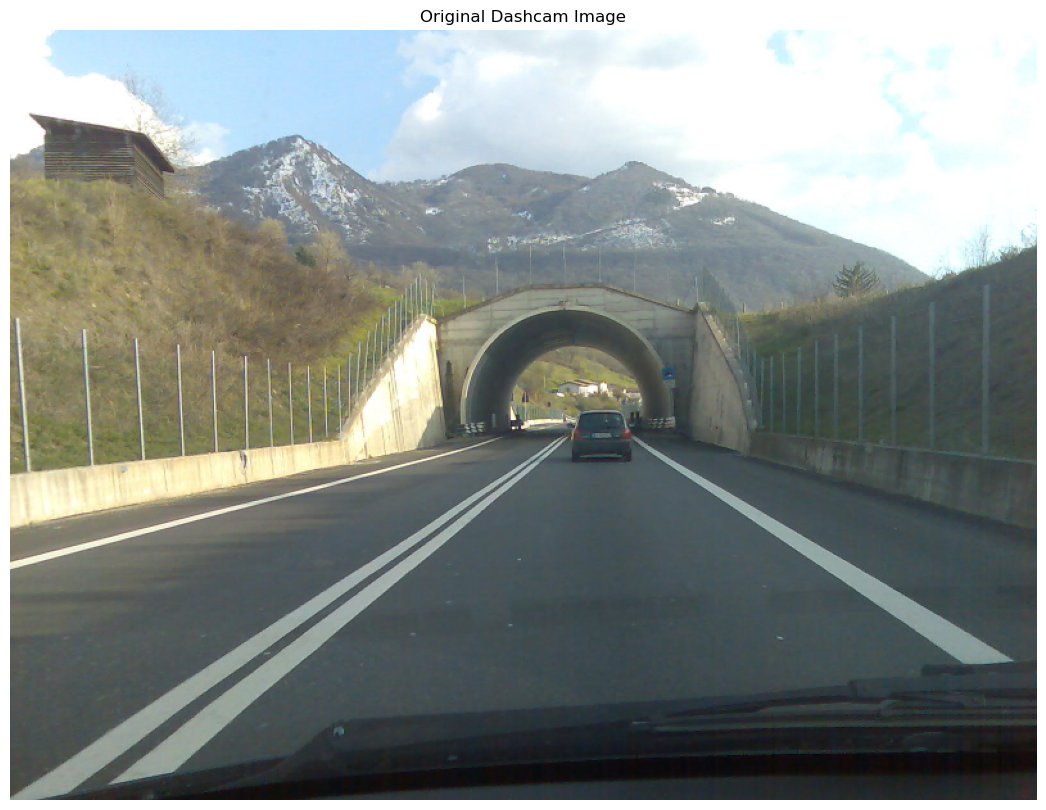

Image shape: (600, 800, 3)


In [15]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

img = cv2.imread('data/dashcam.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None, fx=0.5, fy=0.5)

plt.imshow(img)
plt.title('Original Dashcam Image')
plt.axis('off')
plt.show()

print(f"Image shape: {img.shape}")

In [2]:
# ===== STEP 1: Convert image to gray scale =====
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

print("✅ Converted to grayscale")

✅ Converted to grayscale


In [3]:
# ===== STEP 2: Obtain edge map =====
# Using Canny edge detector with th_low = 100, th_high = 150
edges = cv2.Canny(gray, threshold1=100, threshold2=150)

# We are only interested in the road so we will remove everything above the horizon
edges[0:350] = 0

print("✅ Edge map computed")
print(f"Edge map shape: {edges.shape}")

✅ Edge map computed
Edge map shape: (600, 800)


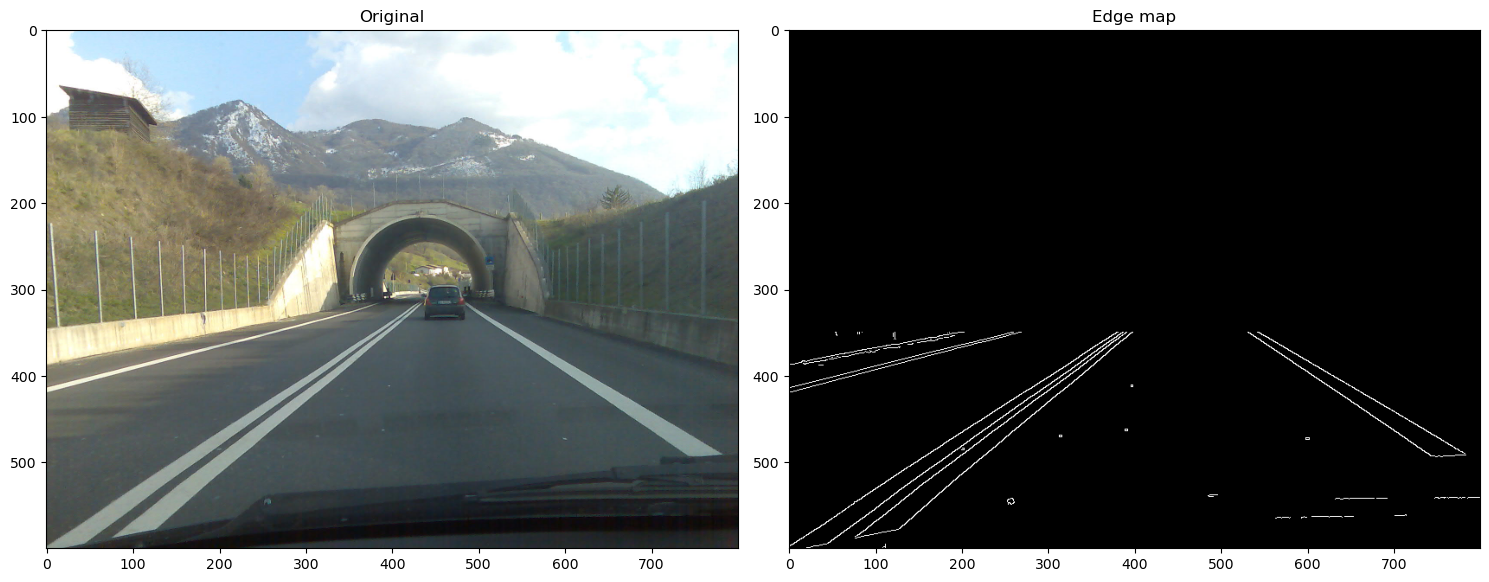

In [4]:
# Let's plot the images
plt.subplot(121), plt.imshow(img), plt.title('Original')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.tight_layout()
plt.show()

In [5]:
# ===== STEP 3: Apply Hough transform =====
# Offset resolution of 2 pixels and slope resolution of 2 degrees
# rho resolution: 2 pixels
# theta resolution: 2 degrees = 2 * np.pi / 180 radians
# accumulator threshold: 190
lines = cv2.HoughLines(edges, rho=2, theta=2*np.pi/180, threshold=190)

# Get rid of the unnecessary dimension
lines = lines[:, 0, :]

print(f"✅ Detected {len(lines)} lines using Hough transform")

✅ Detected 10 lines using Hough transform


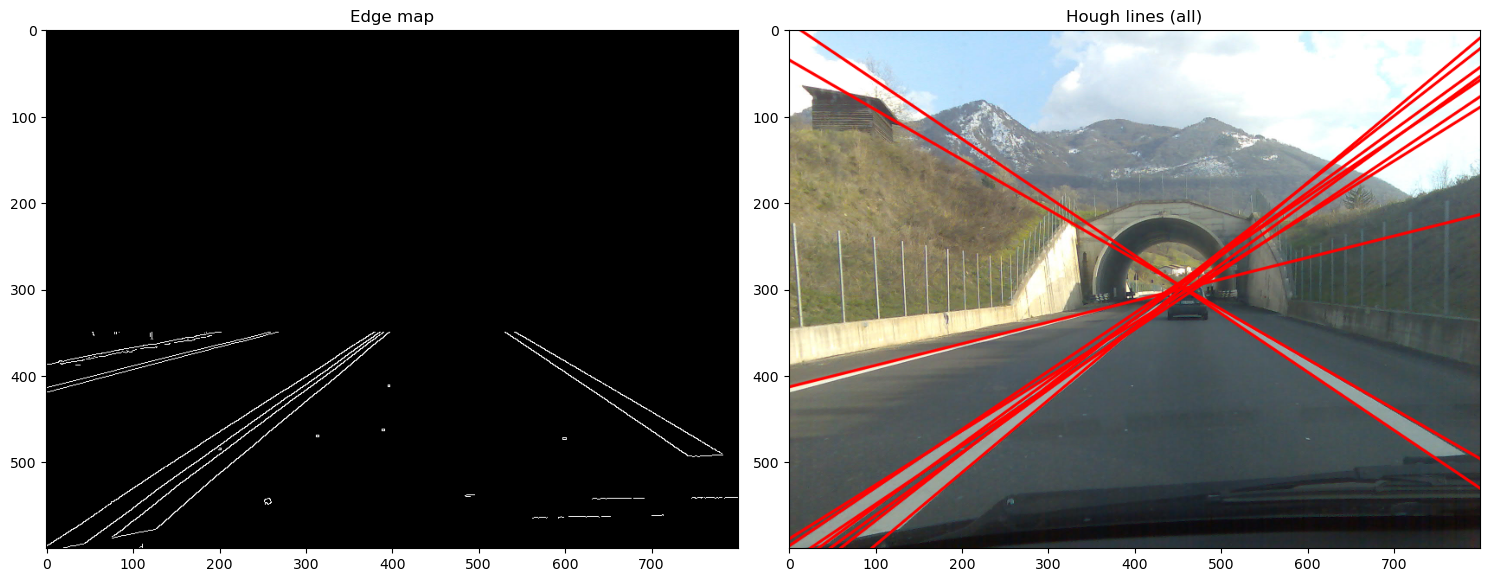

In [6]:
# Plot the resulting Hough lines
result = np.copy(img)
        
for line in lines:
    rho = line[0]
    theta = line[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, (255, 0, 0), 2, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result), plt.title('Hough lines (all)')
plt.tight_layout()
plt.show()

In [7]:
# ===== STEP 4: Filter out horizontal lines =====
# Filter out all lines that are approximately horizontal (+/- 20 degrees)
filtered_lines = []

for line in lines:
    # Extract theta for current line (Hough works with radians)
    theta = line[1]
    
    # Convert to degrees for easier understanding
    theta_deg = theta * 180 / np.pi
    
    # Keep line if theta is NOT approximately horizontal (90 +/- 20 degrees)
    if not (70 <= theta_deg <= 110):
        filtered_lines.append(line)

print(f"✅ Filtered lines: {len(filtered_lines)} (removed {len(lines) - len(filtered_lines)} horizontal lines)")

✅ Filtered lines: 9 (removed 1 horizontal lines)


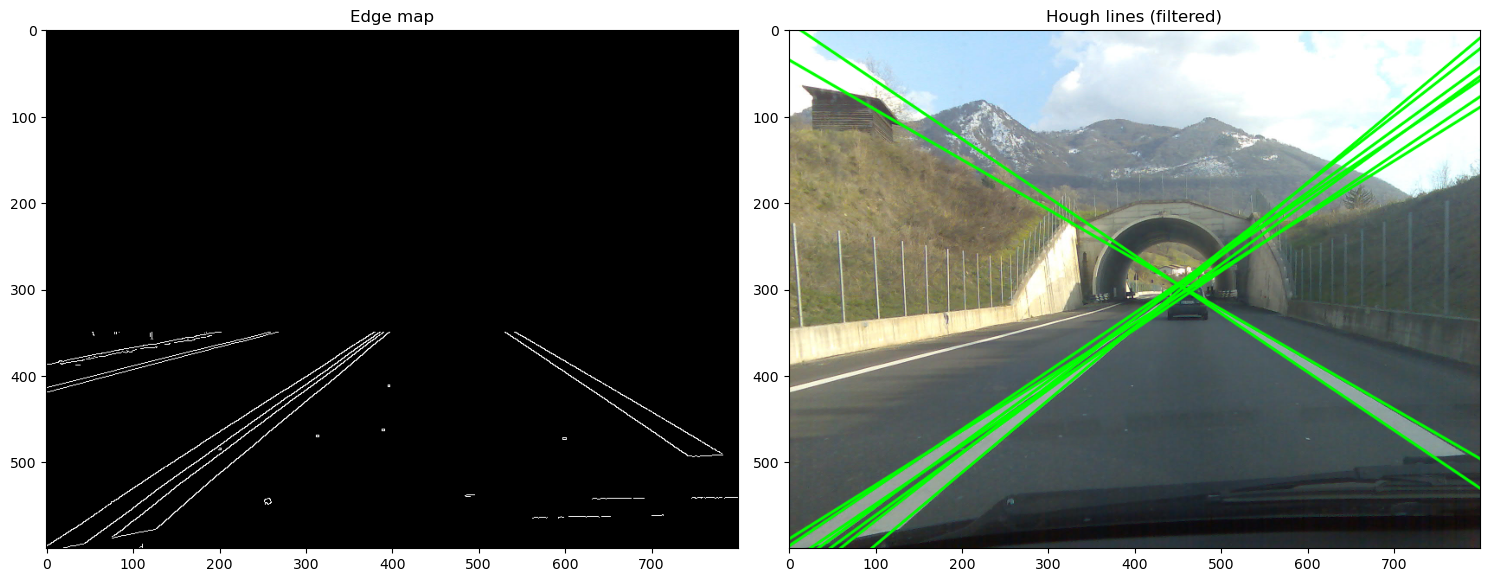

In [8]:
# Let's plot the resulting filtered lines
result = np.copy(img)
 
for line in filtered_lines:
    rho = line[0]
    theta = line[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, (0, 255, 0), 2, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result), plt.title('Hough lines (filtered)')
plt.tight_layout()
plt.show()

In [13]:
# ===== STEP 5: Apply k-means clustering =====
# We will apply k-means clustering to refine the detected lines
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=42, n_init=10).fit(filtered_lines)
cluster_centers = kmeans.cluster_centers_

print(f"✅ K-means clustering applied")
print(f"Cluster centers:\n{cluster_centers}")

✅ K-means clustering applied
Cluster centers:
[[497.           0.99483767]
 [ 31.           2.09439516]
 [521.           0.87266463]
 [ -7.           2.16420817]
 [511.           0.94247778]
 [505.           0.94247776]]


In [14]:
# Plot the final result with clustered lines
result = np.copy(img)
    
for line in cluster_centers:
    rho = line[0]
    theta = line[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, (255, 0, 0), 3, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result), plt.title('Final lane lines (k-means)')
plt.tight_layout()
plt.show()

print("\n✅ Lane line detection completed!")


✅ Lane line detection completed!


In [11]:
!conda install scikit-learn -y

Jupyter detected...
2 channel Terms of Service accepted
Retrieving notices: done
Channels:
 - defaults
Platform: osx-arm64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.11.0
    latest version: 26.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/anaconda3/envs/cv

  added / updated specs:
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cyrus-sasl-2.1.28          |       h5aace77_4         190 KB
    eigen-5.0.1                |       h9e3ec18_0         1.2 MB
    ffmpeg-6.1.1               |       h5e6af82_5         8.2 MB
    gdk-pixbuf-2.44.4          |       hf47f480_0         496 KB
    giflib-5.2.2               |       h80987f9_0          78 KB
    glib-2.86.3                |       h863a760_0         499 KB
    glib-tools

(<Axes: >, <matplotlib.image.AxesImage at 0x31cd1b640>)

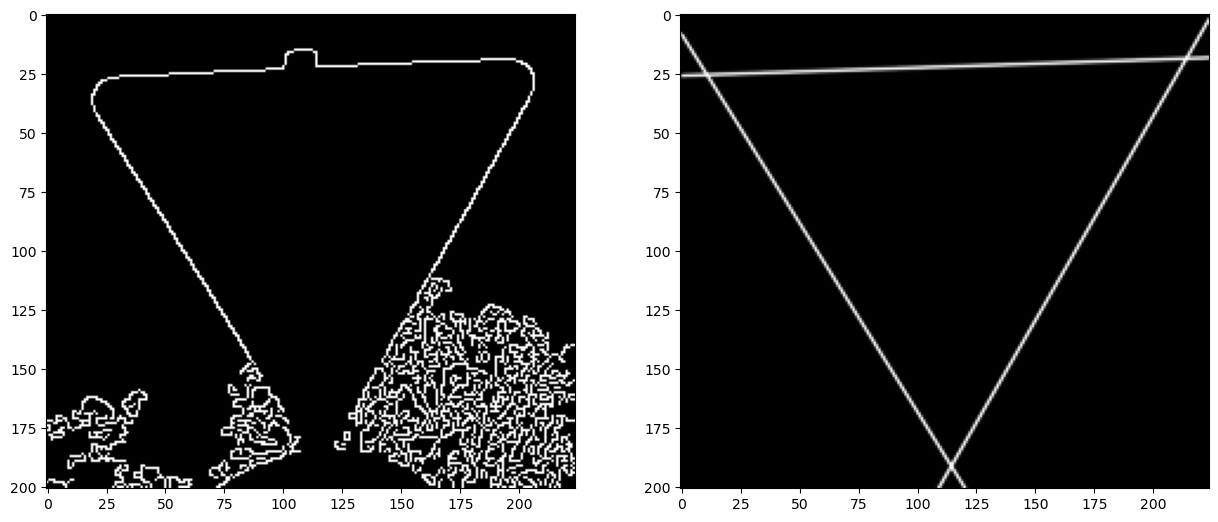

In [16]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
img = cv2.imread('data/yield.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray, threshold1=100, threshold2=550)

plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(edges, cmap='gray')
lines = cv2.HoughLines(edges, rho=1, theta=2*np.pi/180, threshold=50)
hough = np.zeros_like(edges)
    
for i in range(0, len(lines[0:3])):
    rho = lines[i][0][0]
    theta = lines[i][0][1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(hough, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray')
plt.subplot(122), plt.imshow(hough, cmap='gray')